In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [28]:
path = './data/AmesHousing.txt'

data = pd.read_table(path, index_col=0)

In [29]:
data.head(5)

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
Order,,,,,,,,,,,,,,,,,,,,,
1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [30]:
data.shape[0]

2930

According to kaggle description, this dataset doesn't contain any errors in data entries or physically impossible values, but still it's better to check at least date/time features.

In [31]:
time_feats = ['Mo Sold', 'Yr Sold', 'Garage Yr Blt', 'Year Built', 'Year Remod/Add']
print(data[time_feats].isna().sum())

Mo Sold             0
Yr Sold             0
Garage Yr Blt     159
Year Built          0
Year Remod/Add      0
dtype: int64


In [32]:
data[time_feats].describe()

,Mo Sold,Yr Sold,Garage Yr Blt,Year Built,Year Remod/Add
count,2930.000000,2930.000000,2771.000000,2930.000000,2930.000000
mean,6.216041,2007.790444,1978.132443,1971.356314,1984.266553
std,2.714492,1.316613,25.528411,30.245361,20.860286
min,1.000000,2006.000000,1895.000000,1872.000000,1950.000000
25%,4.000000,2007.000000,1960.000000,1954.000000,1965.000000
50%,6.000000,2008.000000,1979.000000,1973.000000,1993.000000
75%,8.000000,2009.000000,2002.000000,2001.000000,2004.000000
max,12.000000,2010.000000,2207.000000,2010.000000,2010.000000


In [33]:
data[data['Garage Yr Blt'].notna()]['Garage Yr Blt'].sort_values()

Order
1555    1895.0
308     1896.0
2600    1900.0
170     1900.0
2636    1900.0
         ...  
105     2010.0
39      2010.0
317     2010.0
46      2010.0
2261    2207.0
Name: Garage Yr Blt, Length: 2771, dtype: float64

We can see that there's one error in data entry for 'Garage Yr Built'. It should be dropped.

In [34]:
data.drop(2261, inplace=True)

Feature 'PID' is useless

In [35]:
# drop column PID, it's useless
data.drop('PID', axis=1, inplace=True)

Let's look for outliers in histograms

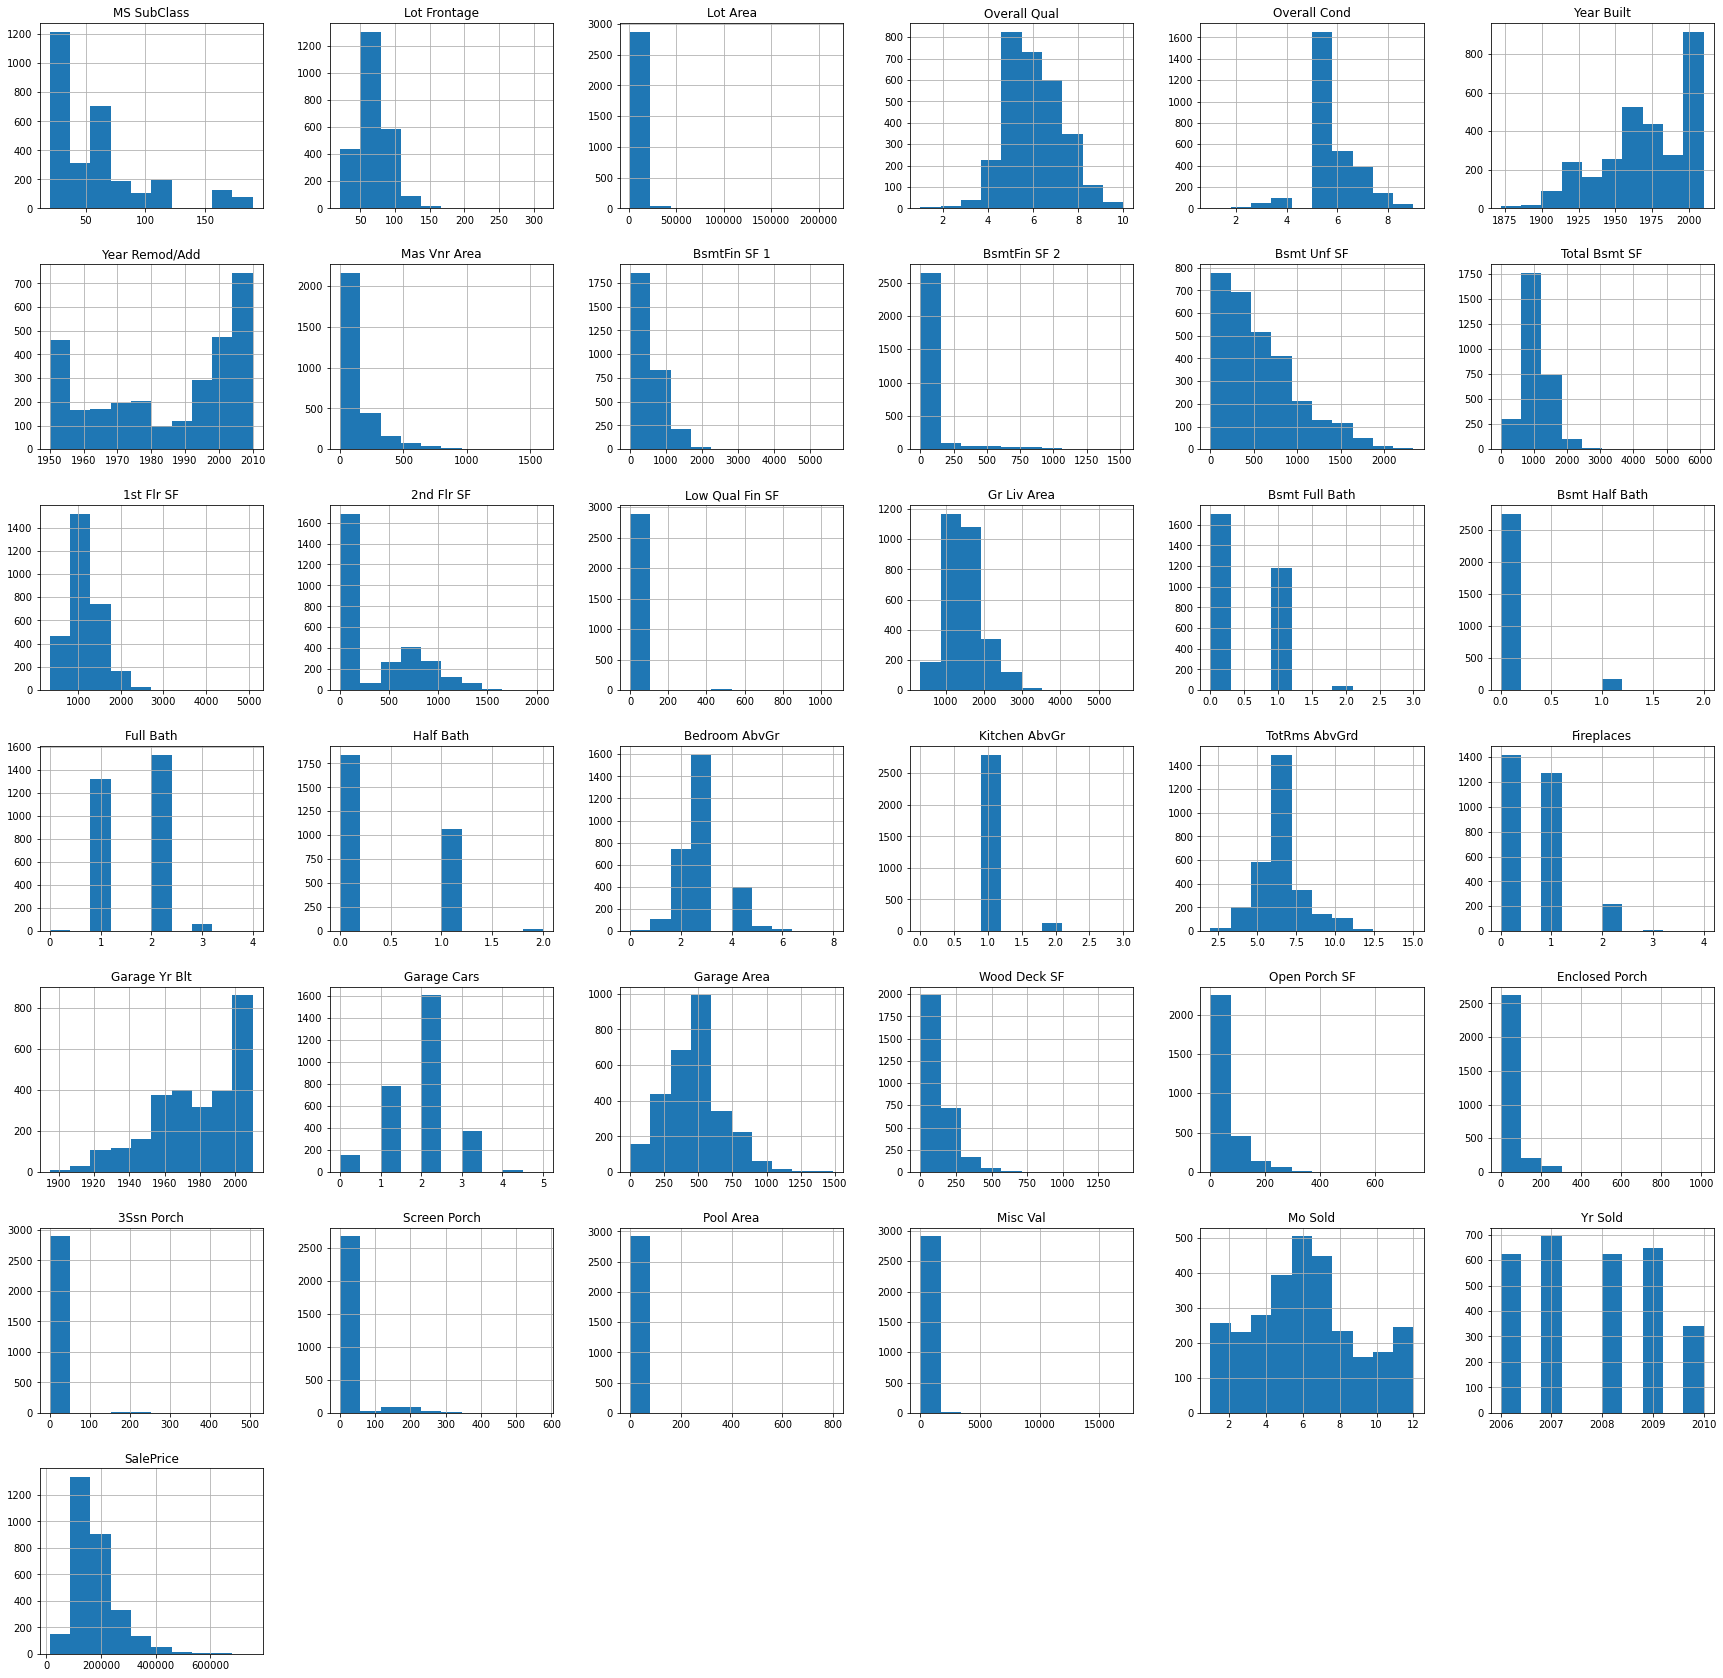

In [36]:
data.hist(figsize=(30, 30));

We can see that the tail of distribution of target varible is very heavy so it should be good to cut it using rule of 3 sigma. Also it seems reasonable to filter 'Garage Area', 'Total Bsmt SF', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Misc Val'.

In [37]:
cols_to_filter = ['SalePrice', 'Garage Area', 'Total Bsmt SF', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Misc Val']
for col in cols_to_filter:
    threshold = data[col].quantile(0.997)
    data = data.loc[data[col] < threshold, :]

Let's check if there are any redundant features

In [38]:
data.count().sort_values()

Pool QC           10
Misc Feature      95
Alley            195
Fence            560
Fireplace Qu    1465
                ... 
Exterior 2nd    2873
Exterior 1st    2873
Roof Matl       2873
BsmtFin SF 1    2873
SalePrice       2873
Length: 80, dtype: int64

We have 3 features which have useful values in less than 10% of all entries. Probably it's best to drop them.

In [39]:
data.drop(['Pool QC', 'Misc Feature', 'Alley'], axis=1, inplace=True)

Let's lower precision for speed purposes

In [40]:
float_cols = data.select_dtypes(include='float64').columns
int_cols = data.select_dtypes(include='int64').columns

data.loc[:, float_cols] = data.loc[:, float_cols].astype('float32')
data.loc[:, int_cols] = data.loc[:, int_cols].astype('int32')

Let's split our columns based on their type.

In [41]:
col_by_type = defaultdict(list)
for index, value in data.dtypes.items():
    col_by_type[str(value)].append(index)

col_by_type.keys()

dict_keys(['int32', 'object', 'float32'])

For all columns with 'object' dtype we'll fill their NaNs with 'missing' value.

In [42]:
data.loc[:, col_by_type['object']] = data.loc[:, col_by_type['object']].fillna('missing')
data.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,3Ssn Porch,Screen Porch,Pool Area,Fence,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
Order,,,,,,,,,,,,,,,,,,,,,
1,20,RL,141.0,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,missing,0,5,2010,WD,Normal,215000
2,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,120,0,MnPrv,0,6,2010,WD,Normal,105000
4,20,RL,93.0,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,missing,0,4,2010,WD,Normal,244000
5,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,MnPrv,0,3,2010,WD,Normal,189900
6,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,missing,0,6,2010,WD,Normal,195500


For columns with 'float32' and 'int32' we'll first inspect unique values, taking into account their total count

In [43]:
float_cols = col_by_type['float32']
val_counts_float_cols = data[float_cols].nunique()
val_counts_float_cols

Lot Frontage       127
Mas Vnr Area       429
BsmtFin SF 1       968
BsmtFin SF 2       262
Bsmt Unf SF       1124
Total Bsmt SF     1025
Bsmt Full Bath       4
Bsmt Half Bath       3
Garage Yr Blt      102
Garage Cars          6
Garage Area        581
dtype: int64

In [44]:
few_unique_vals = val_counts_int_cols[val_counts_int_cols<=10].index
many_unique_vals = val_counts_int_cols[val_counts_int_cols>10].index

for col in few_unique_vals:
    print(col + ': ', data[col].unique())

NameError: name 'val_counts_int_cols' is not defined

In [ ]:
data[col_subset].hist(figsize=(10, 10));

As we can see, these features are in fact integer features with few unique values, so probably it would be best to fill their values with median to preserve data structure

In [ ]:
data[few_unique_vals] = data[few_unique_vals].fillna(data.median()).astype('int32')

In [ ]:
for col in few_unique_vals:
    col_by_type['float32'].remove(col)
    col_by_type['int32'].append(col)

For other 'float32' features we'll use mean values to fill NaNs

In [ ]:
data[many_unique_vals] = data[many_unique_vals].fillna(data.mean())

For 'int32' we'll also fill NaNs with medians for features with low count of unique values\
Others we'll fill with means

In [45]:
int_cols = col_by_type['int32'][:-3]
val_counts_int_cols = data[int_cols].nunique()
val_counts_int_cols

MS SubClass          16
Lot Area           1919
Overall Qual         10
Overall Cond          9
Year Built          118
Year Remod/Add       61
1st Flr SF         1053
2nd Flr SF          625
Low Qual Fin SF      36
Gr Liv Area        1263
Full Bath             5
Half Bath             3
Bedroom AbvGr         8
Kitchen AbvGr         4
TotRms AbvGrd        13
Fireplaces            5
Wood Deck SF        370
Open Porch SF       246
Enclosed Porch      181
3Ssn Porch           31
Screen Porch        119
Pool Area            11
Misc Val             29
dtype: int64

In [46]:
few_unique_vals = val_counts_int_cols[val_counts_int_cols<=10].index
many_unique_vals = val_counts_int_cols[val_counts_int_cols>10].index

data[few_unique_vals] = data[few_unique_vals].fillna(data.median())
data[many_unique_vals] = data[many_unique_vals].fillna(data.mean())

In [47]:
data

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,3Ssn Porch,Screen Porch,Pool Area,Fence,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
Order,,,,,,,,,,,,,,,,,,,,,
1,20,RL,141.0,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,missing,0,5,2010,WD,Normal,215000
2,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,120,0,MnPrv,0,6,2010,WD,Normal,105000
4,20,RL,93.0,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,missing,0,4,2010,WD,Normal,244000
5,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,MnPrv,0,3,2010,WD,Normal,189900
6,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,missing,0,6,2010,WD,Normal,195500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2926,80,RL,37.0,7937,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,0,0,0,GdPrv,0,3,2006,WD,Normal,142500
2927,20,RL,NaN,8885,Pave,IR1,Low,AllPub,Inside,Mod,...,0,0,0,MnPrv,0,6,2006,WD,Normal,131000
2928,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,MnPrv,700,7,2006,WD,Normal,132000
